# Data Science Project - Basketball Analysis

# WARNING: REMOVE ANY CODE TO VIEW THE RAW DATA BEFORE TURNING IN

## Background and Motivation

- One of the popular sports in the U.S. is basketball. One of the most important days in any sport is game day. Prathusha did an internship with the basketball team and this idea fascinated the others. Because of the interest in basketball and the importance of game day, we are trying to predict the performance on game day based on various factors taken into consideration for our home team.
- There are variety of factors taken into consideration for the analysis and prediction. For example, players’ performance leading up to game day, injuries, and the influence of a player on the overall team performance


## Project Objectives

- Prediction of the performance of individual players as game day arrives is based on various deciding factors like injury, player involvement, and other measures of performance for each practice. Game day is quite stressful, but also an important day to perform well. Without adding more pressure on the team to perform well on game day, our analytics will help the home team to win the match based on their performance on each day.
- We will use the factors injury, duration of each player’s practice, and the performance of each of the players as game day approaches, to do supervised and unsupervised analysis. Various factors will be used in these analyses to get maximum achieved performance on game day.
- Implementing strategic analysis methods will increase the probability of the team winning games in the future as well as reduce injuries.


##  Input data

In [8]:
# imports and setup 

import pandas as pd
import numpy as np
import statsmodels.formula.api as sm

from sklearn.cluster import KMeans, AgglomerativeClustering

from sklearn import tree, svm, metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, KFold
from sklearn.preprocessing import scale
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

import re

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)
plt.style.use('ggplot')

In [2]:
analysis_data = pd.read_csv("CS Project Player Data.csv")

In [3]:
game_data = pd.read_csv("CS Project Game Logs.csv", header = 1)

## Exploring the Data

In [4]:
analysis_data.describe()

,InjuryStatus,InjuryType,ActivityType,rpe,dur,minply,trimp,TPR
count,5666.000000,5666.000000,5665.000000,5554.000000,5681.000000,1295.000000,5593.000000,58.000000
mean,0.207201,0.171550,0.883495,2.331847,94.457281,10.820783,307.903487,50.973099
std,0.650988,0.594065,0.675581,1.998314,67.055216,12.345886,300.389405,30.243924
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.304551
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,21.737168
50%,0.000000,0.000000,1.000000,3.000000,119.000000,3.000000,300.000000,52.041566
75%,0.000000,0.000000,1.000000,4.000000,150.000000,21.838889,500.000000,76.506879
max,6.000000,6.000000,3.000000,10.000000,214.000000,47.000000,1712.000000,99.917358


There are ~5500 data recorded. There are very few instances of an injury. Most of the data that is recorded is for practices.

In [5]:
analysis_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5700 entries, 0 to 5699
Data columns (total 13 columns):
PlayerID            5700 non-null object
date                5700 non-null object
InjuryStatus        5666 non-null float64
InjuryType          5666 non-null float64
ActivityType        5665 non-null float64
rpe                 5554 non-null float64
dur                 5681 non-null float64
minply              1295 non-null float64
trimp               5593 non-null float64
Location            3781 non-null object
Opponent            895 non-null object
Date_Act_Loc_Opp    5700 non-null object
TPR                 58 non-null float64
dtypes: float64(8), object(5)
memory usage: 579.0+ KB


In [6]:
num_ath = len(analysis_data.PlayerID.unique())
print("There are " + str(num_ath) + " athletes on the Basketball team.")

There are 25 athletes on the Basketball team.


In [10]:
sm.ols(formula="trimp ~ InjuryStatus", data=analysis_data).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  trimp   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                  0.030
Method:                 Least Squares   F-statistic:                     175.6
Date:                Wed, 28 Mar 2018   Prob (F-statistic):           1.72e-39
Time:                        09:37:47   Log-Likelihood:                -39525.
No. Observations:                5559   AIC:                         7.905e+04
Df Residuals:                    5557   BIC:                         7.907e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      324.6200      4.173     77.789      0.000     316.439     332.801
InjuryStatus   -80.4361      6.069    -13.253      0.000     -92.334     -68.538
==============================================================================
Omnibus:                      446.725   Durbin-Watson:                   1.159
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              559.811
Skew:                           0.770   Prob(JB):                    2.74e-122
Kurtosis:                       3.206   Cond. No.                         1.64
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Injuries on their own do not effect the performance of an athlete.

## Visualization

### Injuries

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001C51A7EB860>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000001C51B47D588>]], dtype=object)

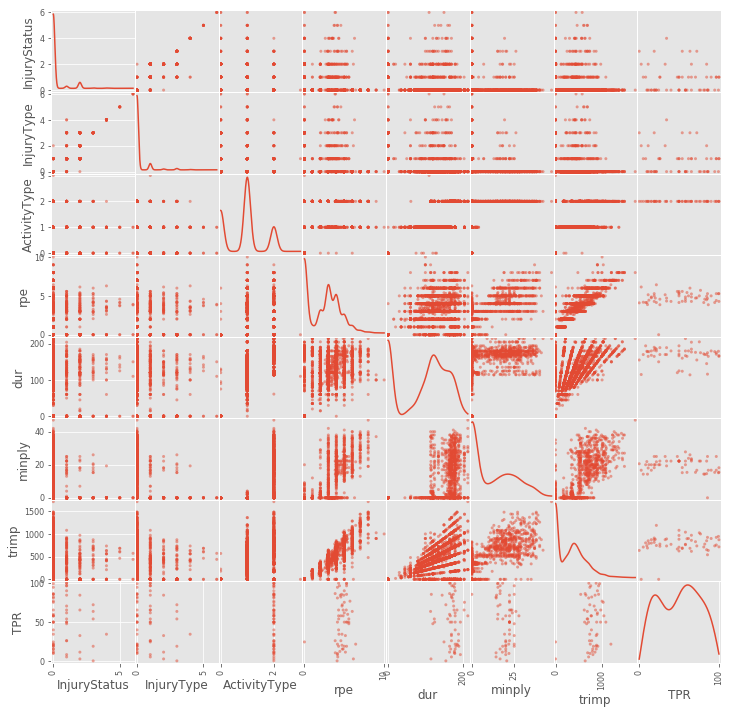

In [14]:
pd.plotting.scatter_matrix(analysis_data, figsize=(12, 12), diagonal='kde')

Here we can see that as an injury stays over time and as the injury type gets more serious, the performance (measured by trimp) of the players goes down. However, when there are no injuries, the performance of a player varies and cannot be easily predicted with simply injury data.

Note: This scatter matrix includes player data and team data. We fix this problem below.

In [26]:
team_data = analysis_data[analysis_data.iloc[:, 0] == "TEAM"]

In [31]:
player_data = analysis_data[analysis_data.iloc[:, 0] != "TEAM"]

Text(0,0.5,'Trimp')

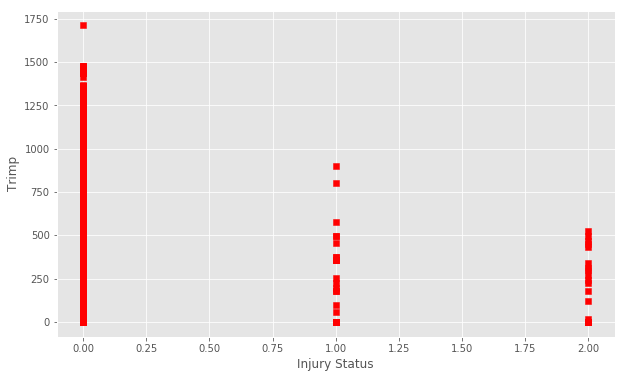

In [29]:
plt.scatter(x=player_data['InjuryStatus'],y=player_data['trimp'],c='r',marker='s')

plt.xlabel('Injury Status')
plt.ylabel('Trimp')

We still show potential for better performance when there are no injuries and decreasing performance as time with the injury continues.

Note: We do not have access to the units for any of these variables.

Text(0,0.5,'Trimp')

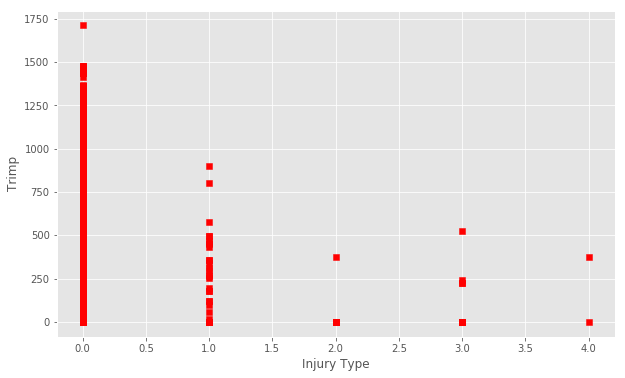

In [30]:
plt.scatter(x=player_data['InjuryType'],y=player_data['trimp'],c='r',marker='s')

plt.xlabel('Injury Type')
plt.ylabel('Trimp')

The intensity of the injury type also decreases the performance of each player.

### Prediction of performance on game day

In [52]:
team_game_data = team_data[team_data.loc[:, "ActivityType"] == 2]

In [53]:
team_game_data.corr()

,InjuryStatus,InjuryType,ActivityType,rpe,dur,minply,trimp,TPR
InjuryStatus,1.000000,0.986437,NaN,0.099876,-0.264160,-0.088512,-0.154925,-0.084130
InjuryType,0.986437,1.000000,NaN,0.007485,-0.292507,-0.098747,-0.233655,-0.108769
ActivityType,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
rpe,0.099876,0.007485,NaN,1.000000,-0.115627,0.187698,0.535579,0.145926
dur,-0.264160,-0.292507,NaN,-0.115627,1.000000,0.192339,0.602358,-0.040042
minply,-0.088512,-0.098747,NaN,0.187698,0.192339,1.000000,0.259664,-0.191937
trimp,-0.154925,-0.233655,NaN,0.535579,0.602358,0.259664,1.000000,0.186496
TPR,-0.084130,-0.108769,NaN,0.145926,-0.040042,-0.191937,0.186496,1.000000


In [54]:
sm.ols(formula="trimp ~ rpe + dur", data=team_game_data).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  trimp   R-squared:                       0.734
Model:                            OLS   Adj. R-squared:                  0.725
Method:                 Least Squares   F-statistic:                     84.20
Date:                Wed, 28 Mar 2018   Prob (F-statistic):           2.84e-18
Time:                        10:32:11   Log-Likelihood:                -383.04
No. Observations:                  64   AIC:                             772.1
Df Residuals:                      61   BIC:                             778.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -895.5821    130.285     -6.874      0.000   -1156.104    -635.060
rpe          138.9142     15.052      9.229      0.000     108.815     169.013
dur            6.0282      0.595     10.129      0.000       4.838       7.218
==============================================================================
Omnibus:                      108.851   Durbin-Watson:                   2.030
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2965.795
Skew:                          -5.328   Prob(JB):                         0.00
Kurtosis:                      34.601   Cond. No.                     1.81e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.81e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

We get that rpe and duration are good estimations of performance on game day. It makes sense that rpe is a good predictor because that is how well the players think they performed.

We do not get a model that promises accurate prediction for every game day, but we can predict 73% of the games correctly with this model.